In [71]:
"""
making input vector to contain last action
"""

'\nmaking input vector to contain last action\n'

In [90]:
import numpy as np
import tensorflow as tf
import statistics
import matplotlib.pyplot as plt
# import pygame as pg
import random
import math
import glob
import os
from PIL import Image
import time

import imageio

In [91]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (180*np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))/math.pi

In [92]:
class MyModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='relu', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

    @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output

In [93]:
class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = MyModel(num_states, hidden_units, num_actions)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.iter = 0
        
    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))
    
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            return 0
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.experience['s'][i] for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        states_next = np.asarray([self.experience['s2'][i] for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_mean(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        self.iter += 1
        return loss
    
    def get_action(self, NN_input, epsilon):
        if random.uniform(0, 1) < epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.predict(np.atleast_2d(NN_input))[0])
        
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

In [154]:
class Agent():
    def __init__(self, isPursuer, position, TargetNet, TrainNet):
        if isPursuer == 'p':
          self.isPursuer = 1
        else:
          self.isPursuer = 0  
        self.position = position
        self.TrainNet = None
        self.TargetNet = None
        self.rewards = []
        self.currReward = 0
        self.losses = []
        self.currLosses = []
        self.lastAction = 0
        self.num_agents_in_radius = []
        self.a_violations = 0

In [155]:
class World():
    def __init__(self, numPursuers, numEvaders):
        self.numPursuers = numPursuers
        self.numEvaders = numEvaders
        self.pursuers = []
        self.evaders = []
        self.radius = 20
        self.action_space_e = [np.array([0,2]),np.array([2,0]),np.array([0,-2]), np.array([-2,0]), 
                               np.array([2,2]), np.array([2,-2]), np.array([-2,2]), np.array([-2,-2]), 
                               np.array([0,1]),np.array([1,0]),np.array([0,-1]), np.array([-1,0]),
                               np.array([1,1]), np.array([1,-1]), np.array([-1,1]), np.array([-1,-1])]
        # Assumption : Pursuer action space starts with (0,0)
        self.action_space_p = [np.array([0,0]), np.array([0,1]),np.array([1,0]),np.array([0,-1]), np.array([-1,0]),
                              np.array([1,1]),np.array([1,-1]),np.array([-1,-1]), np.array([-1,1])]

        # self.action_space_e = [np.array([0,1]),np.array([1,0]),np.array([0,-1]), np.array([-1,0])]        

    def initialize_pursuers(self):
        for i in range(self.numPursuers):
            position_list = self.return_pursuer_positions(self.numPursuers)
            pos_i = position_list[i]
            self.pursuers.append(Agent('p', pos_i, None, None)) 

    def initialize_evaders(self):
        self.evaders.append(Agent('e', np.array((10,10)), None, None))   

    def reset_world(self):
        position_list = self.return_pursuer_positions(self.numPursuers)
        for i in range(self.numPursuers):
            self.pursuers[i].position = position_list[i]
            self.pursuers[i].lastAction = 0
            self.pursuers[i].a_violations = 0
            if len(self.pursuers[i].currLosses)!=0:
                self.pursuers[i].rewards.append(self.pursuers[i].currReward)
                self.pursuers[i].currReward = 0
                self.pursuers[i].losses.append(statistics.mean(self.pursuers[i].currLosses))
                self.pursuers[i].currLosses = []

        for i in range(self.numEvaders):
            self.evaders[i].position = np.array((random.randint(0,19),random.randint(0,19)))
            if len(self.evaders[i].currLosses)!=0:
                self.evaders[i].rewards.append(self.evaders[i].currReward)
                self.evaders[i].currReward = 0
                self.evaders[i].losses.append(statistics.mean(self.evaders[i].currLosses))
                self.evaders[i].currLosses = []        


    def return_pursuer_positions(self, numPursuers):
        position_list = [np.array((random.randint(0,19),random.randint(0,19))) for i in range(self.numPursuers)]
        return position_list

    def get_NN_input(self, state, i, char):
      if char == 'p':
        n = len(state)
#         nearby_agents_actions = []
        # for agent in self.pursuers:
        #     temp_dist = dist = np.linalg.norm(self.pursuers[i].position - agent.position)
        #     if temp_dist < self.radius:
        #         nearby_agents_actions.append(self.action_space_p[agent.lastAction])
        #     agent.num_agents_in_radius()
        
        # nearby_agents_actions = np.array(nearby_agents_actions)
        # mean_of_actions = np.mean(nearby_agents_actions, axis = 0)        
#         nn_input = np.append(state[2*i:2*(i+1)],state[n-2:n])
        nn_input = np.append(state[3*i:3*(i+1)],state[n-3:n])#changed
        
        return nn_input
      else:
          return np.append(self.evaders[0].position,self.pursuers[0].position)
      

    def initialize_NN(self):
        gamma = 0.99
        copy_step = 1000
        # Full state space assumption
#         num_inputs_p = 4 #mean field approximation
        num_inputs_p = 6 #mean field approximation#changed
#         num_inputs_e = (self.numPursuers + self.numEvaders)*2
        num_inputs_e = (self.numPursuers)*3 + (self.numEvaders)*3 #changed
        num_actions_p = len(self.action_space_p)
        num_actions_e = len(self.action_space_e)
        hidden_units_p = [100, 100]
        hidden_units_e = [100, 100]
        max_experiences = 100000
        min_experiences = 512
        batch_size = 512
        lr_p = 1e-4
        lr_e = 1e-4

        for i in range(len(self.pursuers)):
            TrainNet_p = DQN(num_inputs_p, num_actions_p, hidden_units_p, gamma, max_experiences, min_experiences, batch_size, lr_p)
            TargetNet_p = DQN(num_inputs_p, num_actions_p, hidden_units_p, gamma, max_experiences, min_experiences, batch_size, lr_p)
            # TrainNet_p.model = tf.keras.models.load_model('Train_smart_pursuer1')
            # TargetNet_p.model = tf.keras.models.load_model('Target_smart_pursuer1')
            self.pursuers[i].TrainNet = TrainNet_p
            self.pursuers[i].TargetNet = TargetNet_p

        for i in range(len(self.evaders)):
            TrainNet_e = DQN(num_inputs_e, num_actions_e, hidden_units_e, gamma, max_experiences, min_experiences, batch_size, lr_e)
            TargetNet_e = DQN(num_inputs_e, num_actions_e, hidden_units_e, gamma, max_experiences, min_experiences, batch_size, lr_e)
            # TrainNet_p.model = tf.keras.models.load_model('Train_smart_pursuer1')
            # TargetNet_p.model = tf.keras.models.load_model('Target_smart_pursuer1')
            self.evaders[i].TrainNet = TrainNet_e
            self.evaders[i].TargetNet = TargetNet_e


In [156]:
class MarlEnv():

    def __init__(self):
        self.dir = 1
        self.numPursuers = 4
        self.numEvaders = 1
        self.world = World(self.numPursuers, self.numEvaders)
        self.world.initialize_pursuers()
        self.world.initialize_evaders()
        self.world.initialize_NN()        
        self.iter = 0        
#         self.grid = grid
        print("Init")

    def take_action_p(self, i, action):
        self.world.pursuers[i].position += action

    def take_action_e(self, i, action):
        self.world.evaders[i].position += action
           
        
    def step(self, actions_p, actions_e, state):
        violated_p =[]
        violated_e =[]
        dones = []
        rewards_p = []
        rewards_e = []
        agent_num=0
        

        for i in range(self.numPursuers):
            self.world.pursuers[i].lastAction = state[3*agent_num+2] 
            self.take_action_p(i, self.world.action_space_p[actions_p[i]])
            agent_num+=1
            
        for i in range(self.numEvaders):
            self.world.evaders[i].lastAction = state[3*agent_num+2]
            self.take_action_e(i, self.world.action_space_e[actions_e[i]]) 
            agent_num+=1
                                               
        self.iter += 1
        next_state = []
        agent_num = 0
        for agent in self.world.pursuers:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])
            next_state.append(actions_p[agent_num])#changed
            agent_num+=1

            
        agent_num = 0
        for agent in self.world.evaders:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1]) 
            next_state.append(actions_e[agent_num])#changed
            agent_num+=1


        for i in range(self.numPursuers):
            reward, done, violated = self.compute_reward_p(i, next_state)
            self.world.pursuers[i].currReward += reward
            if violated:
                self.take_action_p(i, (-1)*self.world.action_space_p[actions_p[i]])
            rewards_p.append(reward)
            violated_p.append(violated)
            dones.append(done)

        for i in range(self.numEvaders):
            reward, done, violated = self.compute_reward_e(i, next_state)
            self.world.evaders[i].currReward += reward
            if violated:
                self.take_action_e(i, (-1)*self.world.action_space_e[actions_e[i]])
            rewards_e.append(reward)
            violated_e.append(violated)
            dones.append(done)   

        next_state = []
        agent_num = 0
        for agent in self.world.pursuers:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])
            next_state.append(actions_p[agent_num])#changed
            agent_num+=1
            
        agent_num = 0
        for agent in self.world.evaders:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])                      
            next_state.append(actions_e[agent_num])#changed
            agent_num+=1
        
        return next_state, rewards_p, rewards_e, any(dones), violated_p, violated_e

    def compute_reward_p(self, i, state):
        last_action_index = self.world.pursuers[i].lastAction
        curr_action_index = state[3*i+2]
        last_action = self.world.action_space_p[last_action_index]
        curr_action = self.world.action_space_p[curr_action_index]
#         print("P", i, " last action: ", last_action, " Current action: ", curr_action)
        angle = angle_between(np.array(last_action), np.array(curr_action))
        if np.isnan(angle):
#             print(angle)
            angle = 0
#         print("Angle changed: ", angle)
        
#         pursuer_pos = state[2*i: (2*i)+2]
        pursuer_pos = self.world.pursuers[i].position#changed
#         pursuer_pos = state[3*i: (3*i)+2]#changed
        done = False
        violated = False
        r = 0
        if abs(angle)>46.0:
            r = -1
            self.world.pursuers[i].a_violations += 1
            
        dist = np.linalg.norm(pursuer_pos - self.world.evaders[0].position)
        if pursuer_pos[0] <0 or pursuer_pos[0]>19 or pursuer_pos[1] < 0 or pursuer_pos[1] > 19:
            violated = True
            return r-5, False, True
        #one evader assumption
      
        elif np.array_equal(pursuer_pos, self.world.evaders[0].position) or dist<0.5:
            return r+10, True, False

        
#         dist = abs(state[0] - state[2]) + abs(state[1] - state[3])
        dist = dist/(20*math.sqrt(2))
        return r-dist, False, False
#         return -1

    def compute_reward_e(self, i, state):
        # one evader assumption
        evader_pos = self.world.evaders[i].position
        if evader_pos[0] < 0 or evader_pos[0] > 19 or evader_pos[1] < 0 or evader_pos[1] > 19:
            return -5, False, True
        # one pursuer condition
        elif any([np.array_equal(evader_pos, self.world.pursuers[i].position) for i in range(self.world.numPursuers)]):
        # elif np.array_equal(evader_pos, self.world.pursuers[0].position):
            return -10, True, False

        dist = min([np.linalg.norm(evader_pos - self.world.pursuers[i].position) for i in range(self.world.numPursuers)])
        dist = dist/(20*math.sqrt(2))
        return dist, False, False


    def reset(self):
        self.iter = 0
        self.world.reset_world()

    def render(self):
        step_size = 30
        width = 20*step_size
        height = 20*step_size

        pg.init()
        screen = pg.display.set_mode((width+5, height+5))

        screen.fill((255,255,255))

        for x in range(0, width+step_size, step_size):
            pg.draw.line(screen, (0,0,0), (x, 0), (x, height))

        for y in range(0, width+step_size, step_size):
            pg.draw.line(screen, (0,0,0), (0, y), (width, y))
            
#         for i in range(20):
#             for j in range(20):
#                 if self.grid[i,j]==1:
#                     pg.draw.rect(screen, pg.Color("black"), (i*step_size, j*step_size, step_size, step_size))
                    
        red = (255,0,0)
        blue = (0, 0, 128)

        evader_x = (self.evader_p[0] + 0.5)*step_size
        evader_y = (self.evader_p[1] + 0.5)*step_size

        pursuer_x = (self.pursuer_p[0] + 0.5)*step_size
        pursuer_y = (self.pursuer_p[1] + 0.5)*step_size    
        r = 10
        pg.draw.circle(screen, red, (int(evader_x),int(evader_y)), r)
        pg.draw.circle(screen, blue, (int(pursuer_x),int(pursuer_y)), r)
        
        if self.iter < 10:
            pg.image.save(screen, f"Saved/screenshot00{self.iter}.png")
        elif self.iter < 100:
            pg.image.save(screen, f"Saved/screenshot0{self.iter}.png")
        else:
            pg.image.save(screen, f"Saved/screenshot{self.iter}.png")        
        
        pg.display.update()
        pg.time.delay(300)    

    def close(self):
        print("close")

In [157]:
def play_game(env, epsilon_p, epsilon_e, copy_step):
    cumulative_rewards_p = [0 for i in range(env.numPursuers)]
    cumulative_rewards_e = [0 for i in range(env.numEvaders)]

    iter = 0
    done = False
    violated_p = [False for i in range(env.numPursuers)]
    violated_e = [False for i in range(env.numEvaders)]
    env.reset()
    losses_p = []
    losses_e = []
    num_violations_p = [0 for i in range(env.numPursuers)]
    a_violations_p = [0 for i in range(env.numPursuers)]
    num_steps_p = [0 for i in range(env.numPursuers)]
    # steps_to_violation_p = [0 for i in range(env.numPursuers)]
    num_violations_e = [0 for i in range(env.numEvaders)]
    # Assumption
    success = 0
    exceed_limit = 0
    state = []
    for agent in env.world.pursuers:
        state.append(agent.position[0])
        state.append(agent.position[1])
        state.append(0)#changed

    for agent in env.world.evaders:
        state.append(agent.position[0])
        state.append(agent.position[1]) 
        state.append(0)#changed

    while not done:
        actions_p =[]
        NN_input_list = []
        for i in range(env.numPursuers):
            NN_input = env.world.get_NN_input(state, i, 'p')
            NN_input_list.append(NN_input)
            # one evader assumption
            action = env.world.pursuers[i].TrainNet.get_action(NN_input, epsilon_p)
            env.world.pursuers[i].lastAction = action
            actions_p.append(action)
        actions_e = []
        for i in range(env.numEvaders):
            # one evader assumption
            action = env.world.evaders[i].TrainNet.get_action(state, epsilon_e)
            actions_e.append(action)
             
        next_state, reward_p, reward_e, done, violated_p, violated_e = env.step(actions_p, actions_e, state)

        if done:
            success += 1

        for i in range(env.numPursuers):
            if violated_p[i]:
                num_violations_p[i] += 1

        for i in range(env.numEvaders):
            if violated_e[i]:
                num_violations_e[i] += 1

        for i in range(env.numPursuers):
            NN_input=NN_input_list[i]
            next_NN_input = env.world.get_NN_input(next_state, i, 'p')
            exp_p = {'s': NN_input, 'a': actions_p[i], 'r': reward_p[i], 's2': next_NN_input, 'done': done or violated_p[i]}        
            env.world.pursuers[i].TrainNet.add_experience(exp_p)
            loss_p = env.world.pursuers[i].TrainNet.train(env.world.pursuers[i].TargetNet)
            env.world.pursuers[i].currLosses.append(float(loss_p))
            num_steps_p[i] += 1
            if env.world.pursuers[i].TrainNet.iter % copy_step == 0:
                env.world.pursuers[i].TargetNet.copy_weights(env.world.pursuers[i].TrainNet)            

        for i in range(env.numEvaders):
            exp_e = {'s': state, 'a': actions_e[i], 'r': reward_e[i], 's2': next_state, 'done': done or violated_e[i]}        
            env.world.evaders[i].TrainNet.add_experience(exp_e)
            loss_e = env.world.evaders[i].TrainNet.train(env.world.evaders[i].TargetNet)
            env.world.evaders[i].currLosses.append(float(loss_e))
           
            if env.world.evaders[i].TrainNet.iter % copy_step == 0:
                env.world.evaders[i].TargetNet.copy_weights(env.world.evaders[i].TrainNet) 


        if num_steps_p[0]==150:
            exceed_limit = 1
            break
            
        state = next_state.copy()
    for i in range(env.numPursuers):
        a_violations_p[i] = env.world.pursuers[i].a_violations

    return success, exceed_limit, num_violations_p, num_violations_e, a_violations_p, num_steps_p[0]

In [158]:
env = MarlEnv()

Init


In [159]:
training_start = time.time()
N = 1001
# env = MarlEnv()
copy_step = 500
total_violations_p = np.empty(N)
total_a_violations_p = np.empty(N)
total_violations_e = np.empty(N)
total_success = np.empty(N)
total_exceed_limit = np.empty(N)
time_steps_arr = np.empty(N)

logs_size = int(N/100)
episodes = []

avg_a_voilations_percent_log = []
total_voilations_p_log = []
total_voilations_e_log = []
avg_reward_p_log = []
avg_reward_e_log = []
avg_time_steps_log = []
successes_log = []


epsilon_p = 0.9
epsilon_e = 0.9
# epsilon = 0.3
decay = 0.998
min_epsilon = 0.1
for n in range(N):
#     print("Game: ", n)
    epsilon_p = max(min_epsilon, epsilon_p * decay)
    epsilon_e = max(min_epsilon, epsilon_e * decay)
#     epsilon = max(min_epsilon, 0.99*(1-n/N))
    success, exceed_limit, num_violations_p, num_violations_e, a_violations_p, time_steps = play_game(env, epsilon_p, epsilon_e, copy_step)
    total_violations_p[n] = sum(num_violations_p)
    total_a_violations_p[n] = sum(a_violations_p)
    total_violations_e[n] = sum(num_violations_e)
    total_success[n] = success
    time_steps_arr[n] = time_steps
    total_exceed_limit[n] = exceed_limit
    a_violation_percent = 100.0*total_a_violations_p[n]/(env.numPursuers*time_steps)
    print("Game: ", n," Angle violations: ", total_a_violations_p[n], " or ", str(a_violation_percent)+"%")
    


    # total_steps_to_violations[n] = episode_steps_to_violation
    if n>0 and n % 100 == 0:
        print("episode:", n, "eps_p:", epsilon_p,"eps_e:", epsilon_e)
        avg_reward_p_temp = 0
        avg_reward_e_temp = 0
        for i in range(env.numPursuers):
            avg_rewards_p = statistics.mean(env.world.pursuers[i].rewards[max(0, n - 100):(n + 1)])
            print("avg reward_p",i," (last 100):", avg_rewards_p)
            avg_reward_p_temp += avg_rewards_p
        for i in range(env.numEvaders):
            avg_rewards_e = statistics.mean(env.world.evaders[i].rewards[max(0, n - 100):(n + 1)])
            print("avg reward_e",i," (last 100):", avg_rewards_e)
            avg_reward_e_temp += avg_rewards_e
            
        avg_reward_p_temp = avg_reward_p_temp/env.numPursuers
        avg_reward_e_temp = avg_reward_e_temp/env.numEvaders
        
        num_violations_p = total_violations_p[max(0, n - 100):(n + 1)].sum()
        a_violations_p = total_a_violations_p[max(0, n - 100):(n + 1)].sum()
        num_violations_e = total_violations_e[max(0, n - 100):(n + 1)].sum()
        num_success = total_success[max(0, n - 100):(n + 1)].sum()
        num_exceed_limit = total_exceed_limit[max(0, n - 100):(n + 1)].sum()
        avg_time_steps = time_steps_arr[max(0, n - 100):(n + 1)].mean()
        total_time_steps = time_steps_arr[max(0, n - 100):(n + 1)].sum()
        a_violation_percent = 100.0*a_violations_p/(env.numPursuers*total_time_steps)
        # avg_steps_to_violation = total_steps_to_violations[max(0, n - 100):(n + 1)].mean()
        
        print("Successes:",  num_success,"violations (pursuer):", num_violations_p,"violations (evader):", num_violations_e, "total times limit exceeded", num_exceed_limit)
        print("Average steps:", avg_time_steps,"total angle violations (pursuer):", a_violations_p,"angle violations (in %):",str(a_violation_percent)+"%")
        
        print("----------------------------------------------------------------------------------------")
        
        episodes.append(n)
        avg_a_voilations_percent_log.append(a_violation_percent)
        total_voilations_p_log.append(num_violations_p)
        total_voilations_e_log.append(num_violations_e)
        avg_reward_p_log.append(avg_reward_p_temp)
        avg_reward_e_log.append(avg_reward_e_temp)
        avg_time_steps_log.append(avg_time_steps)
        successes_log.append(num_success)
        
# print("avg reward for last 100 episodes:", avg_rewards)
training_end = time.time()
print("Training Time: ", training_end - training_start)

# plt.plot(avg_a_voilations_percent_log)

/var/folders/48/rwk5hx552_52khbgqrs2l7540000gn/T/ipykernel_30219/52330917.py:3: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


Game:  0  Angle violations:  38.0  or  45.23809523809524%
Game:  1  Angle violations:  241.0  or  50.63025210084034%
Game:  2  Angle violations:  310.0  or  51.666666666666664%
Game:  3  Angle violations:  287.0  or  47.833333333333336%
Game:  4  Angle violations:  98.0  or  54.44444444444444%
Game:  5  Angle violations:  164.0  or  49.397590361445786%
Game:  6  Angle violations:  11.0  or  34.375%
Game:  7  Angle violations:  27.0  or  48.214285714285715%
Game:  8  Angle violations:  11.0  or  30.555555555555557%
Game:  9  Angle violations:  30.0  or  34.09090909090909%
Game:  10  Angle violations:  146.0  or  40.55555555555556%
Game:  11  Angle violations:  183.0  or  37.19512195121951%
Game:  12  Angle violations:  15.0  or  34.09090909090909%
Game:  13  Angle violations:  224.0  or  37.333333333333336%
Game:  14  Angle violations:  234.0  or  39.0%
Game:  15  Angle violations:  221.0  or  36.833333333333336%
Game:  16  Angle violations:  181.0  or  37.708333333333336%
Game:  17  An

Game:  131  Angle violations:  13.0  or  14.772727272727273%
Game:  132  Angle violations:  22.0  or  21.153846153846153%
Game:  133  Angle violations:  5.0  or  41.666666666666664%
Game:  134  Angle violations:  27.0  or  17.307692307692307%
Game:  135  Angle violations:  132.0  or  29.464285714285715%
Game:  136  Angle violations:  19.0  or  25.0%
Game:  137  Angle violations:  22.0  or  26.19047619047619%
Game:  138  Angle violations:  3.0  or  10.714285714285714%
Game:  139  Angle violations:  7.0  or  13.461538461538462%
Game:  140  Angle violations:  21.0  or  22.82608695652174%
Game:  141  Angle violations:  7.0  or  12.5%
Game:  142  Angle violations:  59.0  or  28.365384615384617%
Game:  143  Angle violations:  32.0  or  25.0%
Game:  144  Angle violations:  148.0  or  25.694444444444443%
Game:  145  Angle violations:  37.0  or  25.694444444444443%
Game:  146  Angle violations:  39.0  or  23.214285714285715%
Game:  147  Angle violations:  0.0  or  0.0%
Game:  148  Angle violati

Game:  263  Angle violations:  67.0  or  17.63157894736842%
Game:  264  Angle violations:  69.0  or  17.602040816326532%
Game:  265  Angle violations:  23.0  or  17.424242424242426%
Game:  266  Angle violations:  26.0  or  22.413793103448278%
Game:  267  Angle violations:  29.0  or  22.65625%
Game:  268  Angle violations:  20.0  or  25.0%
Game:  269  Angle violations:  16.0  or  26.666666666666668%
Game:  270  Angle violations:  56.0  or  25.925925925925927%
Game:  271  Angle violations:  32.0  or  19.51219512195122%
Game:  272  Angle violations:  10.0  or  17.857142857142858%
Game:  273  Angle violations:  15.0  or  26.785714285714285%
Game:  274  Angle violations:  57.0  or  17.8125%
Game:  275  Angle violations:  56.0  or  21.21212121212121%
Game:  276  Angle violations:  13.0  or  18.055555555555557%
Game:  277  Angle violations:  62.0  or  23.134328358208954%
Game:  278  Angle violations:  21.0  or  21.875%
Game:  279  Angle violations:  54.0  or  17.532467532467532%
Game:  280  A

Game:  396  Angle violations:  24.0  or  14.634146341463415%
Game:  397  Angle violations:  6.0  or  8.333333333333334%
Game:  398  Angle violations:  11.0  or  13.75%
Game:  399  Angle violations:  8.0  or  8.0%
Game:  400  Angle violations:  37.0  or  17.78846153846154%
episode: 400 eps_p: 0.4032641040682629 eps_e: 0.4032641040682629
avg reward_p 0  (last 100): -25.89816307284443
avg reward_p 1  (last 100): -17.27542484543938
avg reward_p 2  (last 100): -16.95014753803816
avg reward_p 3  (last 100): -20.03617991712068
avg reward_e 0  (last 100): -8.460885705778521
Successes: 97.0 violations (pursuer): 283.0 violations (evader): 99.0 total times limit exceeded 4.0
Average steps: 45.118811881188115 total angle violations (pursuer): 3156.0 angle violations (in %): 17.314022383146806%
----------------------------------------------------------------------------------------
Game:  401  Angle violations:  14.0  or  19.444444444444443%
Game:  402  Angle violations:  43.0  or  18.859649122807

Game:  520  Angle violations:  28.0  or  17.073170731707318%
Game:  521  Angle violations:  6.0  or  13.636363636363637%
Game:  522  Angle violations:  15.0  or  14.423076923076923%
Game:  523  Angle violations:  26.0  or  17.105263157894736%
Game:  524  Angle violations:  24.0  or  15.384615384615385%
Game:  525  Angle violations:  42.0  or  14.788732394366198%
Game:  526  Angle violations:  9.0  or  13.235294117647058%
Game:  527  Angle violations:  51.0  or  16.558441558441558%
Game:  528  Angle violations:  12.0  or  13.636363636363637%
Game:  529  Angle violations:  1.0  or  8.333333333333334%
Game:  530  Angle violations:  11.0  or  10.576923076923077%
Game:  531  Angle violations:  4.0  or  6.25%
Game:  532  Angle violations:  3.0  or  7.5%
Game:  533  Angle violations:  9.0  or  10.227272727272727%
Game:  534  Angle violations:  14.0  or  15.217391304347826%
Game:  535  Angle violations:  35.0  or  15.909090909090908%
Game:  536  Angle violations:  9.0  or  9.375%
Game:  537  A

Game:  654  Angle violations:  8.0  or  8.695652173913043%
Game:  655  Angle violations:  22.0  or  10.784313725490197%
Game:  656  Angle violations:  0.0  or  0.0%
Game:  657  Angle violations:  23.0  or  8.846153846153847%
Game:  658  Angle violations:  17.0  or  25.0%
Game:  659  Angle violations:  6.0  or  7.5%
Game:  660  Angle violations:  18.0  or  11.25%
Game:  661  Angle violations:  14.0  or  8.536585365853659%
Game:  662  Angle violations:  25.0  or  8.561643835616438%
Game:  663  Angle violations:  36.0  or  9.574468085106384%
Game:  664  Angle violations:  11.0  or  6.395348837209302%
Game:  665  Angle violations:  19.0  or  7.786885245901639%
Game:  666  Angle violations:  0.0  or  0.0%
Game:  667  Angle violations:  46.0  or  9.05511811023622%
Game:  668  Angle violations:  21.0  or  9.210526315789474%
Game:  669  Angle violations:  51.0  or  11.08695652173913%
Game:  670  Angle violations:  28.0  or  11.11111111111111%
Game:  671  Angle violations:  9.0  or  6.428571428

Game:  790  Angle violations:  21.0  or  7.0%
Game:  791  Angle violations:  8.0  or  8.333333333333334%
Game:  792  Angle violations:  4.0  or  2.9411764705882355%
Game:  793  Angle violations:  2.0  or  7.142857142857143%
Game:  794  Angle violations:  9.0  or  6.818181818181818%
Game:  795  Angle violations:  7.0  or  7.291666666666667%
Game:  796  Angle violations:  6.0  or  3.061224489795918%
Game:  797  Angle violations:  5.0  or  3.5714285714285716%
Game:  798  Angle violations:  9.0  or  5.232558139534884%
Game:  799  Angle violations:  19.0  or  11.585365853658537%
Game:  800  Angle violations:  5.0  or  11.363636363636363%
episode: 800 eps_p: 0.18105314810730258 eps_e: 0.18105314810730258
avg reward_p 0  (last 100): -10.344468098589
avg reward_p 1  (last 100): -12.392528503366092
avg reward_p 2  (last 100): -10.586007116516914
avg reward_p 3  (last 100): -12.242586762894495
avg reward_e 0  (last 100): -7.239519972454845
Successes: 101.0 violations (pursuer): 29.0 violations (

Game:  917  Angle violations:  10.0  or  11.904761904761905%
Game:  918  Angle violations:  13.0  or  6.5%
Game:  919  Angle violations:  12.0  or  6.818181818181818%
Game:  920  Angle violations:  16.0  or  4.597701149425287%
Game:  921  Angle violations:  5.0  or  4.032258064516129%
Game:  922  Angle violations:  0.0  or  0.0%
Game:  923  Angle violations:  10.0  or  5.208333333333333%
Game:  924  Angle violations:  16.0  or  4.705882352941177%
Game:  925  Angle violations:  11.0  or  4.910714285714286%
Game:  926  Angle violations:  25.0  or  6.510416666666667%
Game:  927  Angle violations:  5.0  or  11.363636363636363%
Game:  928  Angle violations:  31.0  or  8.516483516483516%
Game:  929  Angle violations:  10.0  or  5.681818181818182%
Game:  930  Angle violations:  6.0  or  9.375%
Game:  931  Angle violations:  0.0  or  0.0%
Game:  932  Angle violations:  22.0  or  6.962025316455696%
Game:  933  Angle violations:  4.0  or  2.9411764705882355%
Game:  934  Angle violations:  40.0  

In [161]:
print(episodes)

print(avg_a_voilations_percent_log)
print(total_voilations_p_log)
print(total_voilations_e_log)
print(avg_reward_p_log)
print(avg_reward_e_log)
print(avg_time_steps_log)
print(successes_log)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[35.42553191489362, 27.100579470198674, 21.508155295198712, 17.314022383146806, 14.524626317079147, 12.068327577701035, 10.091694772344013, 8.051033875934888, 7.031100019197543, 6.37824235385211]
[1595.0, 593.0, 332.0, 283.0, 131.0, 133.0, 38.0, 29.0, 6.0, 32.0]
[459.0, 131.0, 119.0, 99.0, 73.0, 58.0, 76.0, 63.0, 59.0, 35.0]
[-73.50210559890877, -31.20669015793633, -22.33614711558436, -20.039978843360664, -14.27167204493938, -12.95923511931014, -13.412696501197045, -11.391397620341627, -12.324077092283105, -12.370289660842193]
[-16.441730120514386, -9.6085434395388, -9.925166013983246, -8.460885705778521, -8.187574759949683, -7.66303894984014, -7.136445867911002, -7.239519972454845, -5.300703188222625, -3.7262526733014347]
[83.76237623762377, 47.84158415841584, 43.0990099009901, 45.118811881188115, 40.40594059405941, 40.13861386138614, 46.97029702970297, 45.00990099009901, 51.57425742574257, 51.148514851485146]
[72.0, 97.0, 100.0, 97.

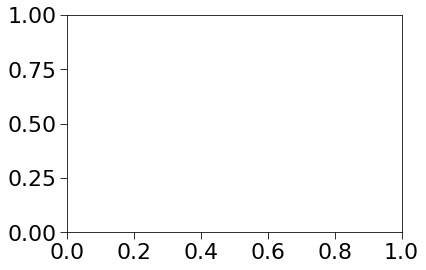

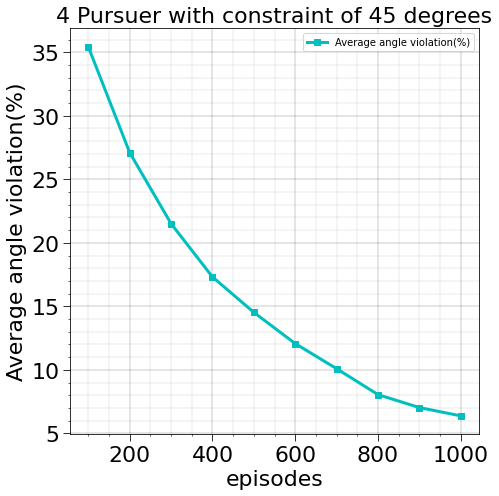

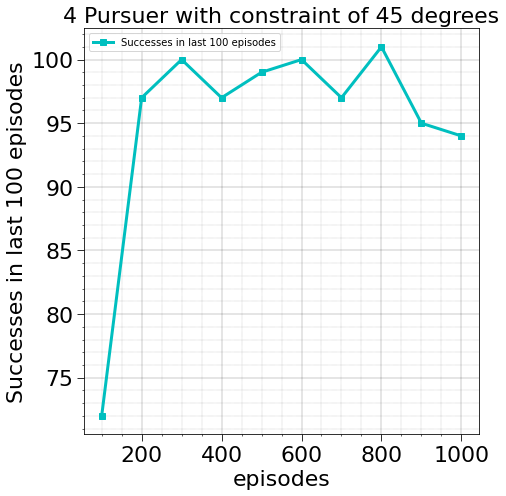

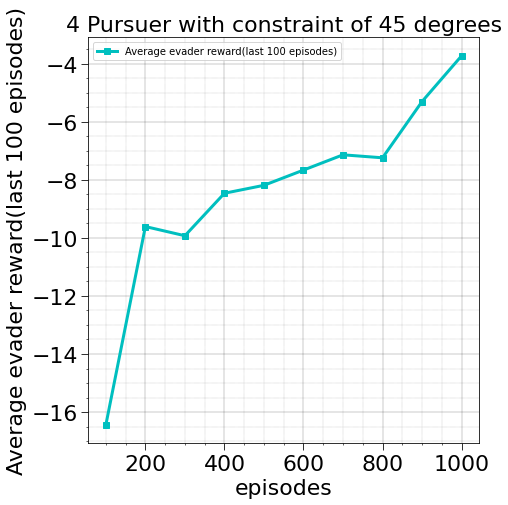

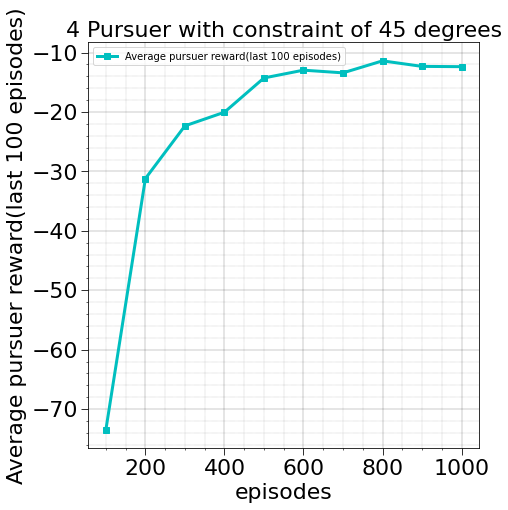

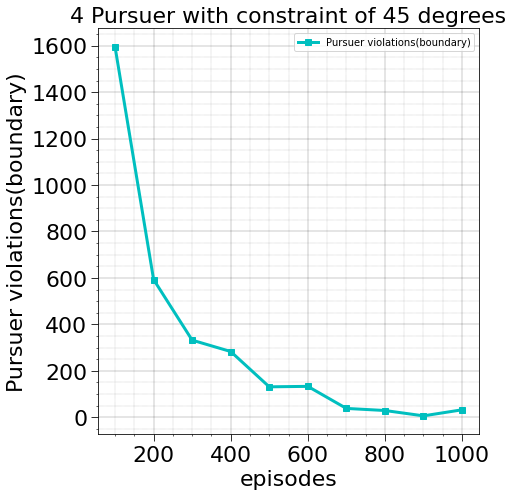

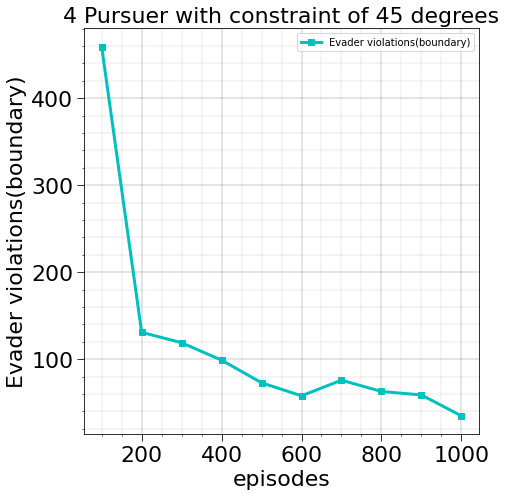

In [163]:
game_name = "4 Pursuer with constraint of 45 degrees"
# plt.plot(episodes, avg_a_voilations_percent_log)
plt.minorticks_off()
#set font style
# plt.rcParams['font.sans-serif'] = 'Helvetica'
#set line width
plt.rcParams['lines.linewidth'] = 3
#set font size for titles 
plt.rcParams['axes.titlesize'] = 22
#set font size for labels on axes
plt.rcParams['axes.labelsize'] = 22
#set size of numbers on x-axis
plt.rcParams['xtick.labelsize'] = 22
#set size of numbers on y-axis
plt.rcParams['ytick.labelsize'] = 22
#set size of ticks on x-axis
plt.rcParams['xtick.major.size'] = 7
#set size of ticks on y-axis
plt.rcParams['ytick.major.size'] = 7
#set size of markers, e.g., circles representing points
#set numpoints for legend
plt.rcParams['legend.numpoints'] = 1

def plotlineargraph(format1,x1,y1, x1label='',y1label='',title1='Untitled',s_name ='',x2='not_given',y2='not_given',y2label='',y1scale=-1,y2scale=-1,  y1err=None):
    fig = plt.figure()
    fig.set_figwidth(7)
    fig.set_figheight(7)
    plt.plot(x1, y1, 'c-s', label = y1label)
    plt.xlabel(x1label)
    plt.ylabel(y1label)
    plt.title(title1)
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.tight_layout()
    #plt.ticklabel_format(style='plain')
    # print('outGraphsfolder ' +outGraphsfolder)
    # print('connector1 '+ connector1)
    # print('s_name '+ s_name)
    # print('title1 '+title1)
    plt.savefig(title1+'_'+s_name+format1)
    plt.show()
    plt.close()


plotlineargraph(".png",episodes,avg_a_voilations_percent_log, 
                x1label='episodes',y1label='Average angle violation(%)',
                title1=game_name,s_name ='Average_angle_violation')
plotlineargraph(".png",episodes,successes_log, 
                x1label='episodes',y1label='Successes in last 100 episodes',
                title1=game_name,s_name ='Successes_in_last_100_episodes')
plotlineargraph(".png",episodes,avg_reward_e_log, 
                x1label='episodes',y1label='Average evader reward(last 100 episodes)',
                title1=game_name,s_name ='Average_evader_reward')
plotlineargraph(".png",episodes,avg_reward_p_log, 
                x1label='episodes',y1label='Average pursuer reward(last 100 episodes)',
                title1=game_name,s_name ='Average_pursuer_reward')
plotlineargraph(".png",episodes,total_voilations_p_log, 
                x1label='episodes',y1label='Pursuer violations(boundary)',
                title1=game_name,s_name ='Pursuer_violations')
plotlineargraph(".png",episodes,total_voilations_e_log, 
                x1label='episodes',y1label='Evader violations(boundary)',
                title1=game_name,s_name ='Evader_violations')

In [164]:
print(env.world.evaders[0].TrainNet.iter)

48964


In [165]:
# #saving to csv
# import pandas as pd 
# import statistics 
# a = env.world.pursuers[0].rewards
# df = pd.DataFrame(a)
# df.to_csv('pursuer_rewards_a_MF1')
# b = env.world.pursuers[1].rewards
# df = pd.DataFrame(b)
# df.to_csv('pursuer_rewards_b_MF1')
# c = env.world.pursuers[2].rewards
# df = pd.DataFrame(c)
# df.to_csv('pursuer_rewards_c_MF1')
# d = env.world.pursuers[3].rewards
# df = pd.DataFrame(d)
# df.to_csv('pursuer_rewards_d_MF1')

# df = pd.DataFrame(env.world.evaders[0].losses)
# df.to_csv('evader_losses_MF1')
# df = pd.DataFrame(env.world.pursuers[1].losses)
# df.to_csv('pursuer_losses_MF1')

# avg_reward = [statistics.mean(k) for k in zip(a, b,c,d)]
# df = pd.DataFrame(avg_reward)  


# df.to_csv('avg_pursuer_training_reward_MF1.csv')
# df = pd.DataFrame([sum(total_violations_p[i:i+10]) for i in range(0, len(total_violations_p),10)])
# df.to_csv('total_pursuer_violations_MF1')
# df = pd.DataFrame([sum(total_violations_e[i:i+10]) for i in range(0, len(total_violations_e),10)])
# df.to_csv('total_evader_violations_MF1')




#Testing

In [168]:

def play_game_test(env):
    make_gif = True
    plot_plot = True
    done = False
    violated_p = [False for i in range(env.numPursuers)]
    violated_e = [False for i in range(env.numEvaders)]
    xp = [[] for i in range(env.numPursuers)]
    yp = [[] for i in range(env.numPursuers)]
    xe = [[] for i in range(env.numEvaders)]
    ye = [[] for i in range(env.numEvaders)]
    env.reset()
    losses_p = []
    losses_e = []
    num_violations_p = [0 for i in range(env.numPursuers)]
    num_steps_p = [0 for i in range(env.numPursuers)]
    # steps_to_violation_p = [0 for i in range(env.numPursuers)]
    num_violations_e = [0 for i in range(env.numEvaders)]
    # Assumption
    success = 0
    exceed_limit = 0
#     env.render()
    state = []
    for agent in env.world.pursuers:
        state.append(agent.position[0])
        state.append(agent.position[1])
        state.append(0)#changed

    for agent in env.world.evaders:
        state.append(agent.position[0])
        state.append(agent.position[1])
        state.append(0)#changed
        
        
    for i in range(env.numPursuers + env.numEvaders):
        if(i<env.numPursuers):
            xp[i].append(state[3*i])
            yp[i].append(state[3*i+1])
        else:
            xe[i-env.numPursuers].append(state[3*i])
            ye[i-env.numPursuers].append(state[3*i+1])

    while not done:
        actions_p =[]
        for i in range(env.numPursuers):
            NN_input = env.world.get_NN_input(state, i, 'p')
            # one evader assumption
            action = env.world.pursuers[i].TrainNet.get_action(NN_input, 0)
            env.world.pursuers[i].lastAction = action 
            actions_p.append(action)           
        actions_e = []
        for i in range(env.numEvaders):
            # one evader assumption
            action = env.world.evaders[i].TrainNet.get_action(state, 0)
            actions_e.append(action)
             
        next_state, reward_p, reward_e, done, violated_p, violated_e = env.step(actions_p, actions_e, state)
#         env.render()
        for i in range(env.numPursuers + env.numEvaders):
            if(i<env.numPursuers):
                xp[i].append(next_state[3*i])
                yp[i].append(next_state[3*i+1])
            else:
                xe[i-env.numPursuers].append(next_state[3*i])
                ye[i-env.numPursuers].append(next_state[3*i+1])
        
        if done:
            success += 1

        for i in range(env.numPursuers):
            if violated_p[i]:
                num_violations_p[i] += 1

        for i in range(env.numEvaders):
            if violated_e[i]:
                num_violations_e[i] += 1

        num_steps_p[0] += 1
        if num_steps_p[0]==150:
            exceed_limit = 1
            break

        state = next_state.copy()
        
        
    if make_gif:
        filenames = []
        for j in range(len(xp[0])):
            fig = plt.figure()
            fig.set_figwidth(10)
            fig.set_figheight(10)

            ax = fig.add_subplot(1, 1, 1)

            major_ticks = np.arange(0, 21, 1)+0.5
            ax.set_xticks(major_ticks)
            ax.set_yticks(major_ticks)
            ax.grid(which='both')
            ax.grid(which='major', alpha=0.5)

            plt.ylim(-0.5,20.5)
            plt.xlim(-0.5,20.5)
            plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
            plt.grid(visible = True)
            plt.ylim(0,20)
            plt.xlim(0,20)
            for i in range(env.numPursuers):
                if j>3:
#                     x = np.array(xp[i][j-3:j+1])
#                     y = np.array(yp[i][j-3:j+1])
#                     plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
#                                scale_units='xy', angles='xy', scale=1, color = 'green', 
#                                width = 0.001, headwidth = 20, headaxislength = 10, headlength = 10)
                    plt.plot(xp[i][j-3:j+1], yp[i][j-3:j+1], 'g-')
                plt.plot(xp[i][j], yp[i][j], marker="o", markersize=10, markeredgecolor="green",markerfacecolor="green")
            for i in range(env.numEvaders):
                if j>3:
                    plt.plot(xe[i][j-3:j+1], ye[i][j-3:j+1], 'r-')
                plt.plot(xe[i][j], ye[i][j], marker="o", markersize=10, markeredgecolor="red",markerfacecolor="red")

            # create file name and append it to a list
            filename = f'{j}.png'
            filenames.append(filename)

            # save frame
            plt.savefig(filename)
            plt.close()
        # build gif
        with imageio.get_writer('mygif.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)

    #     Remove files
        for filename in set(filenames):
            os.remove(filename)
            
            
    if plot_plot:
        # Plotting the trajectory
        fig = plt.figure()
        fig.set_figwidth(10)
        fig.set_figheight(10)

        ax = fig.add_subplot(1, 1, 1)

        major_ticks = np.arange(0, 21, 1)+0.5
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.grid(which='both')
        ax.grid(which='major', alpha=0.5)

        plt.ylim(-0.5,20.5)
        plt.xlim(-0.5,20.5)
        plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)
        plt.grid(visible = True)
        
    
        for i in range(env.numPursuers):
            x = np.array(xp[i])
            y = np.array(yp[i])
            plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                       scale_units='xy', angles='xy', scale=1, color = 'green', 
                       width = 0.001, headwidth = 20, headaxislength = 10, headlength = 10)
            plt.plot(xp[i][0], yp[i][0], marker="o", markersize=10, markeredgecolor="green",markerfacecolor="green")
            
        
        for i in range(env.numEvaders):
            x = np.array(xe[i])
            y = np.array(ye[i])
            plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                       scale_units='xy', angles='xy', scale=1, color = 'red', 
                       width = 0.001, headwidth = 20, headaxislength = 10, headlength = 10)

            plt.plot(xe[i][0], ye[i][0], marker="o", markersize=10, markeredgecolor="red",markerfacecolor="red")
            plt.plot(xe[i][-1], ye[i][-1], marker="*", markersize=15, markeredgecolor="red",markerfacecolor="white")
            
   
        plt.savefig('trajectory.png')
        plt.show()

    return success, exceed_limit, num_violations_p, num_violations_e, num_steps_p[0]

/var/folders/48/rwk5hx552_52khbgqrs2l7540000gn/T/ipykernel_30219/52330917.py:3: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)
/var/folders/48/rwk5hx552_52khbgqrs2l7540000gn/T/ipykernel_30219/2449481702.py:130: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


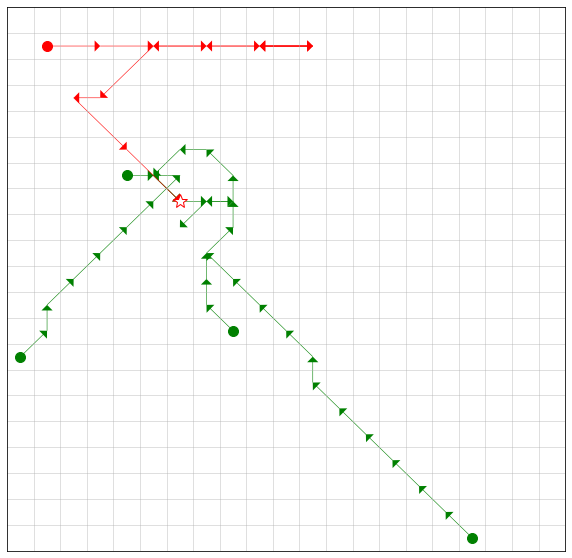

1
Successes: 1/1
Success rate: 1.0
Average steps:  16.0


In [175]:
test_episodes = 1
steps_taken = []
for i in range(test_episodes):
    success, exceed_limit, num_violations_p, num_violations_e, time_steps = play_game_test(env)
    print(success)
    # print(exceed_limit)
    if success:
        steps_taken.append(time_steps)
        
        
print("Successes: " + str(len(steps_taken))+"/"+str(test_episodes))
print("Success rate: "+str(len(steps_taken)/test_episodes))
print("Average steps: ", np.mean(steps_taken))